For this project, I will import data hosted by the City of Oakland featuring the entirety of 911 calls, including the location and nature of the calls as well as the time the call took place. 

In [1]:
import os

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import json
import ast
import datetime as dt
from dateutil import tz
from dateutil import parser
import matplotlib.pyplot as plt
import time
import sklearn
from math import sqrt

In [3]:
print('\n'.join(os.listdir('../Final Project/data'))) 

beat9x_map.jpg
oaklandareaids.png
records-for-2011.csv
records-for-2012.csv
records-for-2013.csv
records-for-2014.csv
records-for-2015.csv
records-for-2016.csv
socrata_metadata_records-for-2011.json
socrata_metadata_records-for-2012.json
socrata_metadata_records-for-2013.json
socrata_metadata_records-for-2014.json
socrata_metadata_records-for-2015.json
socrata_metadata_records-for-2016.json


In [4]:
path_template = './data/records-for-'
df = pd.read_csv(path_template + '2011.csv', sep = ',',header = 0) #Here we create a template for importing the csv files and combining them

In [5]:
recent_data = 2017
for i in range (2012, recent_data):
    df_load = pd.read_csv(path_template+str(i)+".csv", sep=",", header=0)
    if "Location " in df_load.columns:
        df_load = df_load.drop("Location ", axis=1)
    if "Location 1" in df_load.columns:
        df_load["Location"] = df_load["Location 1"]
        df_load = df_load.drop("Location 1", axis=1)
    df = df.append(df_load, ignore_index=True, sort=False)
    print(len(df))
    del df_load

df.head()

367447
555499
742979
935560
1046388


,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2011-01-01T00:00:00.000,ST&SAN PABLO AV,1,06X,1.0,PDOA,POSSIBLE DEAD PERSON,LOP110101000001,2011-01-01T00:28:17.000
1,OP,2011-01-01T00:01:11.000,ST&HANNAH ST,1,07X,1.0,415GS,415 GUNSHOTS,LOP110101000002,2011-01-01T01:12:56.000
2,OP,2011-01-01T00:01:25.000,ST&MARKET ST,1,10Y,2.0,415GS,415 GUNSHOTS,LOP110101000003,2011-01-01T00:07:20.000
3,OP,2011-01-01T00:01:35.000,PRENTISS ST,2,21Y,2.0,415GS,415 GUNSHOTS,LOP110101000005,2011-01-01T00:02:28.000
4,OP,2011-01-01T00:02:10.000,AV&FOOTHILL BLVD,2,20X,1.0,415GS,415 GUNSHOTS,LOP110101000004,2011-01-01T00:50:04.000


In [6]:
crimes_2011 = pd.read_csv('../Final Project/data/records-for-2011.csv')
crimes_2012 = pd.read_csv('../Final Project/data/records-for-2012.csv')
crimes_2013 = pd.read_csv('../Final Project/data/records-for-2013.csv')
crimes_2014 = pd.read_csv('../Final Project/data/records-for-2014.csv')
crimes_2015 = pd.read_csv('../Final Project/data/records-for-2015.csv')
crimes_2016 = pd.read_csv('../Final Project/data/records-for-2016.csv')

In [7]:
df.shape 

(1046388, 10)

In [8]:
df.drop('Agency',axis = 1,inplace = True)

In [9]:
df.shape

(1046388, 9)

In [10]:
df = df.rename(index = str, columns = {'Incident Type Id':'Incident_Type_Id','Area Id':'Area_Id','Create Time':'Create_Time','Incident Type Description':'Incident_Type_Description','Event Number':'Event_Number','Closed Time':'Closed_Time'})

In [11]:
zero_priority = df.loc[df['Priority'] == 0]
df.dropna(how = 'any', axis = 0, inplace = True)
df= df[df.Priority != 0]
df.reset_index(drop=True)
print(len(zero_priority))

24


In [12]:
df.Priority.value_counts()

2.0    527662
1.0    147211
Name: Priority, dtype: int64

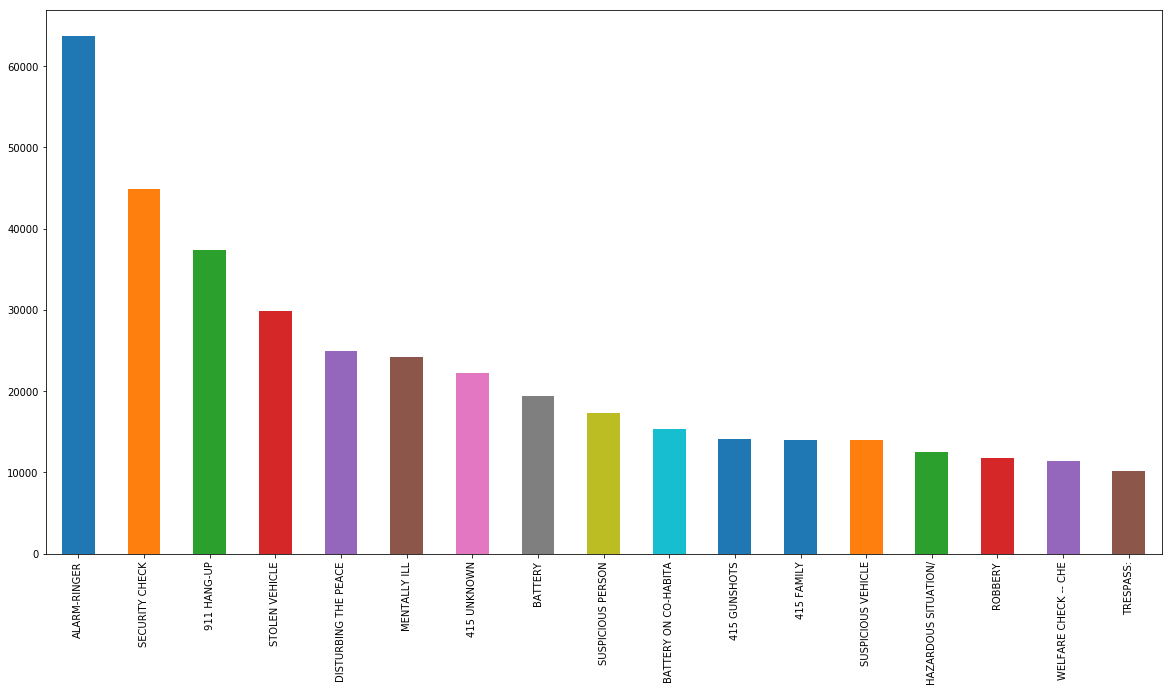

In [13]:
crime_counts= df.Incident_Type_Description.value_counts()
top_crimes = crime_counts[crime_counts> 10000]
top_crimes.plot(kind = 'bar',figsize=(20,10))

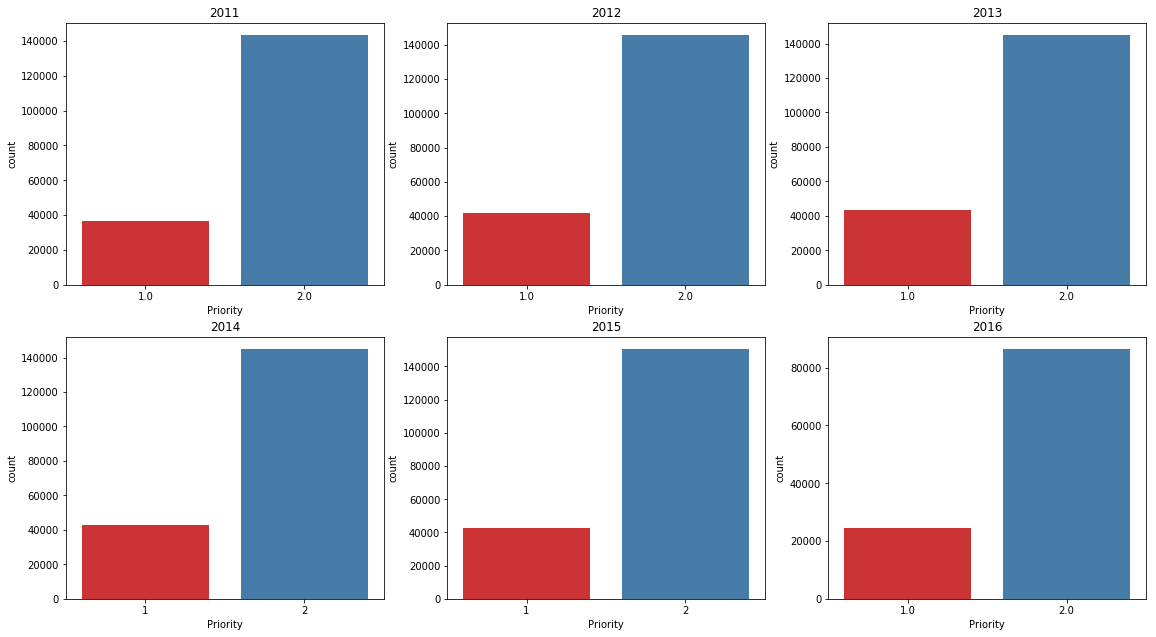

In [14]:
crimes_2011 = crimes_2011[crimes_2011.Priority > 0]
crimes_2013 = crimes_2013[crimes_2013.Priority > 0]
crimes_2015 = crimes_2015[crimes_2015.Priority > 0]
fig, ax = plt.subplots(nrows=2, ncols=3)
plt.subplots_adjust(left=0, right=2.5, top=3, bottom=1)
crimes_list = [crimes_2011, crimes_2012, crimes_2013, crimes_2014, crimes_2015, crimes_2016]
i = 0
for row in ax:
    for col in row:
        col.set_title(str(2011 + i))
        sns.countplot(data=crimes_list[i], x="Priority", ax=col, palette="Set1")
        i+=1

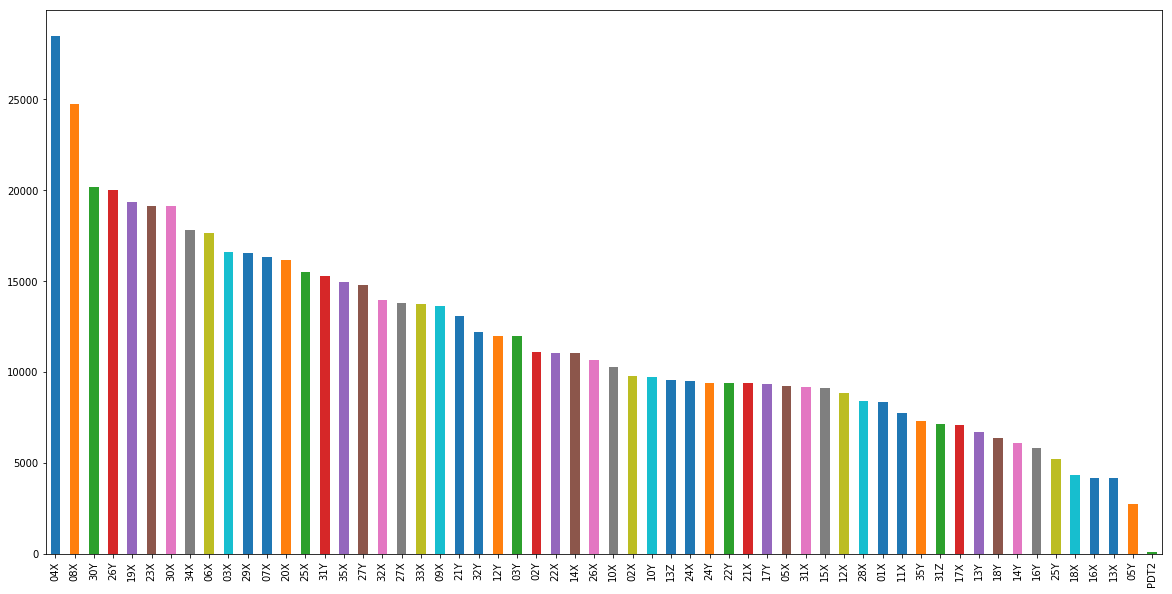

In [15]:
df.Beat.value_counts().plot(kind='bar',figsize = (20,10))

Below is the beat map for the city of Oakland. It can be seen from the bar graph above that beat 04X and beat 08X are the top beats in terms of 911 calls originating from the areas.

<img src = "../Final Project/data/beat9x_map.jpg">

In [16]:
df['Time_Created'] =  pd.to_datetime(df['Create_Time'], format='%Y-%m-%dT%H:%M:%S')
df['Time_Closed'] =  pd.to_datetime(df['Closed_Time'], format='%Y-%m-%dT%H:%M:%S')
df["Time_to_resolve"] = df['Time_Closed'] - df['Time_Created']
df["Time_to_resolve"] = df["Time_to_resolve"].dt.total_seconds()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 674873 entries, 0 to 1046386
Data columns (total 12 columns):
Create_Time                  674873 non-null object
Location                     674873 non-null object
Area_Id                      674873 non-null object
Beat                         674873 non-null object
Priority                     674873 non-null float64
Incident_Type_Id             674873 non-null object
Incident_Type_Description    674873 non-null object
Event_Number                 674873 non-null object
Closed_Time                  674873 non-null object
Time_Created                 674873 non-null datetime64[ns]
Time_Closed                  674873 non-null datetime64[ns]
Time_to_resolve              674873 non-null float64
dtypes: datetime64[ns](2), float64(2), object(8)
memory usage: 66.9+ MB
None


In [17]:
df.Time_to_resolve.mean()/60**2

2.93482121903759

In [27]:
import regex
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

              Incident_Type_Id
Time_Created                  
2011-01-01                 499
2011-01-02                 379
2011-01-03                 460
2011-01-04                 409
2011-01-05                 477


C:\Users\keane\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


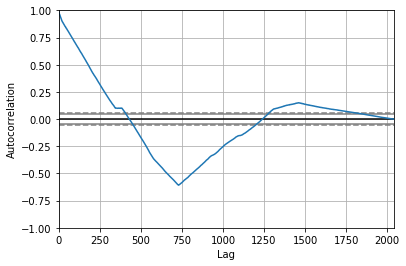

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1529
Model:                     ARMA(1, 1)   Log Likelihood               -7784.154
Method:                       css-mle   S.D. of innovations             39.285
Date:                Sun, 03 Mar 2019   AIC                          15576.307
Time:                        04:57:34   BIC                          15597.637
Sample:                             0   HQIC                         15584.246
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        306.1335    106.439      2.876      0.004      97.516     514.751
ar.L1.y        0.9942      0.003    381.964      0.000       0.989       0.999
ma.L1.y       -0.3267      0.026    -12.700      0.0

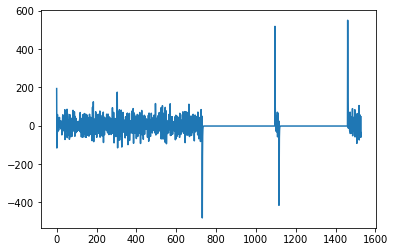

                 0
count  1529.000000
mean     -0.210419
std      39.608545
min    -482.076211
25%      -3.252784
50%      -2.635890
75%       5.204559
max     549.364110
True Observation: [532 519 491 572 563]
Predicted Observation: [306.13345088 496.28859172 413.28093988 443.99887777 419.82397669]


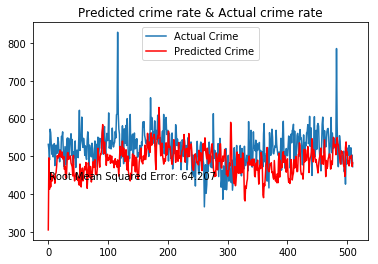

In [29]:
time_col = ["Time_Created", "Incident_Type_Id"] 

time_df = df.drop([c for c in df.columns if c not in time_col], axis=1)#Create a df with two columns, time created and incident type id
time_df = time_df.pivot_table(index="Time_Created", aggfunc=len) #Use the .pivot_table method to aggregate incident id's under creation date index
time_df = time_df.resample("D").sum() #Now that the data is aggregated under a datetime index, we can resample to get crimes/day

print(time_df.head())
X = time_df["Incident_Type_Id"].values #Create a series with the incident type ID column
test_size = int(len(X) * 0.75) #For the time series forecast, we use 0.75 as the test size
X_train, X_test = X[:test_size], X[test_size:] #Tried using sklearn's train test split method but had to make X_train and X_test manually.

#Now that we have a nice DataFrame and a train-test data split, we can start modelling. First, we can find the autocorrelation
#using the pandas visualization tool autocorrelation_plot

autocorrelation_plot(time_df)
plt.show()
model = ARIMA(X_train, order=(1,0,1)) #Instantiate an ARIMA model object. 
fit1 = model.fit() #Create the fitted model

print(fit1.summary())

residuals = pd.DataFrame(fit1.resid) 
plt.plot(residuals)
plt.show()
print(residuals.describe())


prediction = fit1.predict()[:len(X_test)] #Create a prediction of the same length as the testing data for comparison and error computation
print("True Observation:", X_test[0:5]) #Here we print out some observations from the test data
print("Predicted Observation:",prediction[0:5]) #Observations from the predicted data.
rmse = sqrt(mean_squared_error(np.array(X_test), np.array(prediction))) #Calculate the error. RMSE seemed like the best metric to use

plt.figure(1) #Now for the plot of the model against the actual data itself. 
plt.title("Predicted crime rate & Actual crime rate")
plt.plot(X_test, label="Actual Crime")
plt.plot(prediction, label="Predicted Crime", color="red") # +40 because it seems to be systematically underreporting
plt.text(1,100,"Root Mean Squared Error: {} \n ".format(round(rmse,3)), fontsize=10)
plt.legend(loc='upper center')
plt.show()


                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1529
Model:             SARIMAX(1, 0, 1)x(1, 0, 2, 1)   Log Likelihood               -7783.344
Date:                           Sun, 03 Mar 2019   AIC                          15578.688
Time:                                   02:48:04   BIC                          15610.682
Sample:                                        0   HQIC                         15590.595
                                          - 1529                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9971      0.695      1.435      0.151      -0.364       2.359
ma.L1         -0.4478      0.030    -15.117

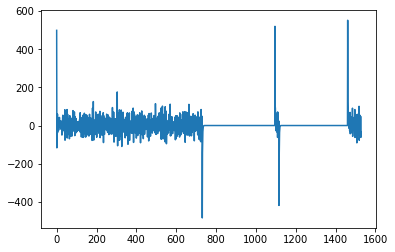

                 0
count  1529.000000
mean      1.228286
std      41.259225
min    -484.432448
25%      -3.769763
50%       0.009248
75%       5.291875
max     552.003470
True Observation: [532. 519. 491. 572. 563.]
Predicted Observation: [  0.         496.11861957 408.31974573 450.67820742 417.48687289]


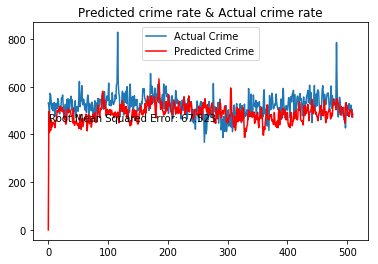

In [28]:
fit2 = sm.tsa.statespace.SARIMAX(X_train, order=(1, 0, 1), seasonal_order=(1,0,2,1)).fit()


print(fit2.summary())

residuals = pd.DataFrame(fit2.resid)
plt.plot(residuals)
plt.show()
print(residuals.describe())


prediction = fit2.predict()[:len(X_test)]
print("True Observation:", X_test[0:5])
print("Predicted Observation:",prediction[0:5])
rmse = sqrt(mean_squared_error(np.array(X_test), np.array(prediction)))

plt.figure(1)
plt.title("Predicted crime rate & Actual crime rate")
plt.plot(X_test, label="Actual Crime")
plt.plot(prediction, label="Predicted Crime", color="red") 
plt.text(1,409,"Root Mean Squared Error: {} \n ".format(round(rmse,3)), fontsize=10)
plt.legend(loc='upper center')
plt.show()
